## Deep troll (Gemidao do Whatsapp) detector



Cansado de ser pego nessas brincadeiras sem graça do Whatsapp? Já ficou em alguma saia justa? 

Vamos colocar o Deep Learning para trabalhar para o bem! O deeptroll usa um modelo de aprendizado profundo que identifica se um áudio contém o Gemidao (AAAWN OOOWN NHAAA AWWWWN AAAAAH).

O modelo usa uma arquitetura RNN-GRU, usando convoluções em espectrogramas de áudio para extrair as features.


In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from spectrogram import *
from td_utils import *
%matplotlib inline
import sys,os,os.path


#from apiclient.discovery import build
from httplib2 import Http
from oauth2client import file, client, tools

# Coleta dos dados: Criando o dataset de audios

We start by building a dataset for the troll detection algorithm. We would like to detect the "troll" in Whatsapp audios. We thus need to create recordings with a mix of positive sounds ("AAAWN OOOWN NHAAA AWWWWN AAAAAH") and negative words (regular whatsapp audios).]

   Colocamos em uma pasta chamada `data` (automating the download would be a nice contribution to start :)


In [2]:
# DOWNLOAD before running this cell -> 'https://drive.google.com/file/d/1wBfrJ7UPC0BLJZlJRlSZgSHxC_YButiF/view?usp=sharing'
#% tar -xzvf deeptroll-data.tar.gz


## Listening to the data   

In the downloaded raw_data directory, you can find a total of 454 whatsapp audio files. We use these audio files to synthesize a dataset to train the model. The "troll" directory contains positive examples of people screaming "AAAWN OOOWN NHAAA AWWWWN AAAAAH". The "regular" directory contains the regular examples of Whatsapp audio files.

The audio files range from 10 seconds to 5 minutes audio clips

Run the cells below to listen to some examples.

In [3]:
IPython.display.Audio("data/raw_data/audios/1.mp3")

In [4]:
IPython.display.Audio("data/raw_data/audios/2.mp3")


We will use two types of recordings (regular/troll) to create a labeled dataset.

# Data cleaning

As the inputs to the model are the spectrograms, we need to extract the dimensions of the audio files after parsing them to spectrograms. Once the raw data audio files have different sizes, they would generate different input sizes, which would not work for our model. For that reason, I've trimmed the audio files to 30 seconds clips.

To clean the audio files, I've used ffmpeg. First, we need to convert the raw_mp3 original files, to the wav format, which works better with our audio manipulation libs:

```
for i in *.mp3;
  do name=`echo $i | cut -d'.' -f1`;
  echo $name;
  ffmpeg -i "$i" -acodec pcm_u8 -ar 22050 "${name}.wav";
done
```

Then we trim the audio files to 30 seconds audio clips, in order to make the input size of our model fixed.

```
for i in *.wav;
  do name=`echo $i | cut -d'.' -f1`;
  echo $name;
  ffmpeg -t 30 -i "$i" 30-"$i";
done
```


Unfortunately, after converting and trimming, the 454 raw audio files dropped to 112 due to some kind of parsing problem. If you manage to increase this number, please, send your contribution so that we can get a better training set.

(101, 8267)


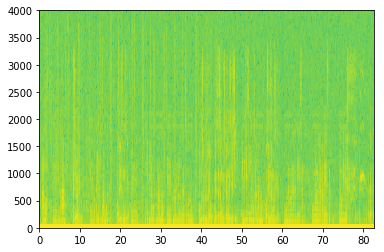

In [5]:
x = graph_spectrogram("./data/train/regular/4.wav")
print(x.shape)
Tx = 8267 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

We will encode our output in a $T_y = 2064$ vector representation, so:

In [6]:
Ty = 2064 # The number of time steps in the output of our model

## 1.3 - Generating a single training example

Because speech data is hard to acquire and label, we are synthesizing our training data using the audio clips of regular and trolls.

To synthesize a single training example, we will:

- Pick a random 30 seconds regular audio clip
- Randomly insert 0-4 audio clips of "trolls" into this 30sec clip

Because we had synthesized the "trolls" into the regular clips, we know exactly when in the 30sec clip the "troll" makes its appearance. We use that as our labels in the training set.

In [7]:
# vamos carregar os segmentos usando o pydub 
troll, regulars = load_raw_audio()


print("Regular len: " + str(len(regulars[3])))    # Deve ser aproximadamente 30,000, pois é um pedaço de 30 segundos, artificial.
print("Troll[0] len: " + str(len(troll[0])))     # Aproximadamente 5000, pois é o clip troll 

Regular len: 30000
Troll[0] len: 4990


**Overlaying trolls on the regular clips**:

Given a 30sec regular clip and a troll clip, we need to be able to "add" or "insert" the troll audio clip onto the regular. To ensure audio segments inserted onto the regular do not overlap, we will keep track of the times of previously inserted troll clips.

**Creating the labels at the same time we overlay**:

Given a regular clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "troll." 

When we insert or overlay a "troll" clip, we will also update labels for $y^{\langle t \rangle}$, so that 50 steps of the output now have target label 1. We will train a GRU to detect when a troll has *finished* playing. 

To implement the training set synthesis process, we will use the following helper functions. All of these function will use a 1ms discretization interval, so the 30sec of audio is alwsys discretized into 30,000 steps. 

1. `get_random_time_segment(segment_ms)` gets a random time segment in our regular audio
2. `is_overlapping(segment_time, existing_segments)` checks if a time segment overlaps with existing segments
3. `insert_audio_clip(background, audio_clip, existing_times)` inserts an audio segment at a random time in our regular audio using `get_random_time_segment` and `is_overlapping`
4. `insert_ones(y, segment_end_ms)` inserts 1's into our label vector y after the word "activate"

In [8]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    print(segment_ms*2)
    segment_start = np.random.randint(low=0, high=30000-segment_ms*2)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [9]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time

    overlap = False
    
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [10]:
def insert_audio_clip(regular, audio_clip, previous_segments):
    """
    Insert a new audio segment over the regular clip at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 30 second regular audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_regular -- the updated regular audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    
    while (is_overlapping(segment_time, previous_segments)):
        segment_time = get_random_time_segment(segment_ms)

    previous_segments.append(segment_time)
    
    # Vamos colocar o audio por cima. Vamos abaixar em 50 dB o som nesse momento 
    new_regular = regular.overlay(audio_clip, position = segment_time[0], gain_during_overlay=-50.0)
    
    return new_regular, segment_time

9980
Segment Time:  (17161, 22150)


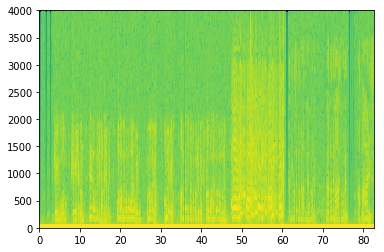

In [11]:
audio_clip, segment_time = insert_audio_clip(regulars[5], troll[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
graph_spectrogram("insert_test.wav")
IPython.display.Audio("insert_test.wav")


Finally, we update the labels $y^{\langle t \rangle}$, assuming we just inserted a "troll". In the code below, `y` is a `(1,2064)` dimensional vector, since $T_y = 2064$. 

```
    segment_end_y = int(segment_end_ms * Ty / 30000.0)
```

In [12]:
def insert_ones(y, segment_start_ms, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_start_y = int(segment_start_ms * Ty / 30000.0)
    segment_end_y = int(segment_end_ms * Ty / 30000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y+1, segment_end_y+1+50):
        if i < Ty:
            y[0, i] = 1
    
    return y

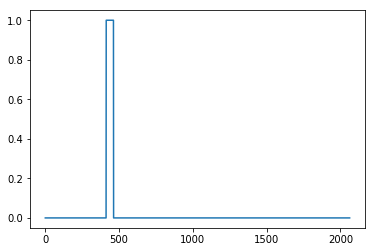

In [13]:
arr1 = insert_ones(np.zeros((1, Ty)), 5000, 6000)
plt.plot(arr1[0])

Finally, we can use `insert_audio_clip` and `insert_ones` to create a new training example.

In [102]:
def create_training_example(regular, trolls, file_name):
    """
    Creates a training example with a given a regular clip and a troll.
    
    Arguments:
    regular -- a 30 second regular audio clip
    troll -- a list of audio segments of the "troll"
    file_name -- nome_do_arquivo
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make regular quieter
    #regular = regular - 20

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    
    # Select our "troll" audio clip
    # we currently have only one :(
    
    # Insert the audio clip on the regular
    regular, segment_time = insert_audio_clip(regular, trolls[0], previous_segments)
    # Retrieve segment_start and segment_end from segment_time
    segment_start, segment_end = segment_time[0], segment_time[1]
    # Insert labels in "y"
    print(segment_start)
    print(segment_end)
    y = insert_ones(y, segment_start, segment_end)

    # Standardize the volume of the audio clip 
    #regular = match_target_amplitude(regular, -20.0)

    # Export new training example 
    file_handle = regular.export(file_name, format="wav")
    print("File ({}) was saved in your directory.".format(file_name))
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram(file_name)
    
    return x, y

9980
9580
14569
File (train.wav) was saved in your directory.


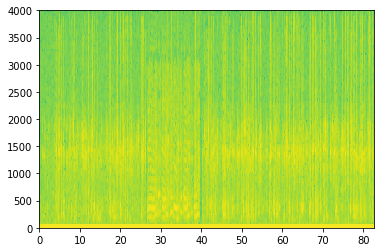

In [103]:
x, y = create_training_example(regulars[100], troll, "train.wav")

Lets listen to the training example we created and compare it to the spectrogram generated above.

In [104]:
IPython.display.Audio("train.wav")

Finally, we can plot the associated labels for the generated training example.

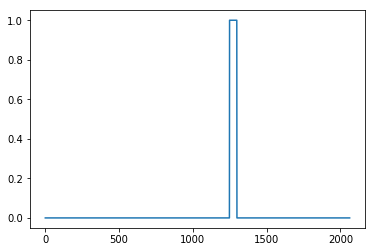

In [17]:
plt.plot(y[0])

## 1.4 - Full training set

We use this process to generate our training set. 

data/train_generated/0.wav
9980
14340
19329
File (data/train_generated/0.wav) was saved in your directory.
data/train_generated/1.wav
9980
7814
12803
File (data/train_generated/1.wav) was saved in your directory.
data/train_generated/2.wav
9980
18610
23599
File (data/train_generated/2.wav) was saved in your directory.
data/train_generated/3.wav
9980
3185
8174
File (data/train_generated/3.wav) was saved in your directory.
data/train_generated/4.wav
9980
4115
9104
File (data/train_generated/4.wav) was saved in your directory.
data/train_generated/5.wav
9980
2280
7269
File (data/train_generated/5.wav) was saved in your directory.
data/train_generated/6.wav
9980
4038
9027
File (data/train_generated/6.wav) was saved in your directory.
data/train_generated/7.wav
9980
3828
8817
File (data/train_generated/7.wav) was saved in your directory.
data/train_generated/8.wav
9980
5748
10737
File (data/train_generated/8.wav) was saved in your directory.
data/train_generated/9.wav
9980
12337
17326
File 

data/train_generated/76.wav
9980
1319
6308
File (data/train_generated/76.wav) was saved in your directory.
data/train_generated/77.wav
9980
8689
13678
File (data/train_generated/77.wav) was saved in your directory.
data/train_generated/78.wav
9980
11535
16524
File (data/train_generated/78.wav) was saved in your directory.
data/train_generated/79.wav
9980
15619
20608
File (data/train_generated/79.wav) was saved in your directory.
data/train_generated/80.wav
9980
3923
8912
File (data/train_generated/80.wav) was saved in your directory.
data/train_generated/81.wav
9980
6917
11906
File (data/train_generated/81.wav) was saved in your directory.
data/train_generated/82.wav
9980
10688
15677
File (data/train_generated/82.wav) was saved in your directory.
data/train_generated/83.wav
9980
7478
12467
File (data/train_generated/83.wav) was saved in your directory.
data/train_generated/84.wav
9980
11482
16471
File (data/train_generated/84.wav) was saved in your directory.
data/train_generated/85.wa

data/train_generated/152.wav
9980
19554
24543
File (data/train_generated/152.wav) was saved in your directory.
data/train_generated/153.wav
9980
1932
6921
File (data/train_generated/153.wav) was saved in your directory.
data/train_generated/154.wav
9980
15183
20172
File (data/train_generated/154.wav) was saved in your directory.
data/train_generated/155.wav
9980
15476
20465
File (data/train_generated/155.wav) was saved in your directory.
data/train_generated/156.wav
9980
11215
16204
File (data/train_generated/156.wav) was saved in your directory.
data/train_generated/157.wav
9980
19344
24333
File (data/train_generated/157.wav) was saved in your directory.
data/train_generated/158.wav
9980
12791
17780
File (data/train_generated/158.wav) was saved in your directory.
data/train_generated/159.wav
9980
17801
22790
File (data/train_generated/159.wav) was saved in your directory.
data/train_generated/160.wav
9980
6954
11943
File (data/train_generated/160.wav) was saved in your directory.
data

data/train_generated/228.wav
9980
13713
18702
File (data/train_generated/228.wav) was saved in your directory.
data/train_generated/229.wav
9980
13931
18920
File (data/train_generated/229.wav) was saved in your directory.
data/train_generated/230.wav
9980
869
5858
File (data/train_generated/230.wav) was saved in your directory.
data/train_generated/231.wav
9980
3688
8677
File (data/train_generated/231.wav) was saved in your directory.
data/train_generated/232.wav
9980
7454
12443
File (data/train_generated/232.wav) was saved in your directory.
data/train_generated/233.wav
9980
13133
18122
File (data/train_generated/233.wav) was saved in your directory.
data/train_generated/234.wav
9980
5691
10680
File (data/train_generated/234.wav) was saved in your directory.
data/train_generated/235.wav
9980
12981
17970
File (data/train_generated/235.wav) was saved in your directory.
data/train_generated/236.wav
9980
7494
12483
File (data/train_generated/236.wav) was saved in your directory.
data/trai

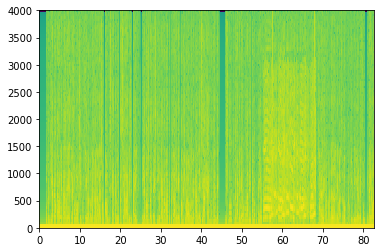

In [105]:
X = []
Y = []

for i, regular in enumerate(regulars):
    print("data/train_generated/{}.wav".format(i))
    x, y = create_training_example(regular, troll, "data/train_generated/{}.wav".format(i))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

## 1.5 - Development set

**TODO:** To test the model, we have a development set of 7 samples of actual trolls the needs to be labeled them by hand, to create a development set using the same distribution as the real inputs. The raw audios are stored in `data/test`, within the downloaded dataset.

For now, I'm using the same synthesized data to test de model (not a good approach, so, if you can, please send your contribution with the labeled dev set)


In [70]:
# Load preprocessed dev set examples
# X_dev = np.load("./XY_dev/X_dev.npy")
# Y_dev = np.load("./XY_dev/Y_dev.npy")

# Temos isso de dimentcao
print(X.shape) 
numero_de_amostras = len(X)

train_size = int(numero_de_amostras * 0.6)

dev_size = numero_de_amostras - train_size

print("Temos {} elementos no total. Vou seperar {} para treino e {} para testes".format(numero_de_amostras, train_size, dev_size))

X_train, X_dev = X[:train_size,:], X[train_size:,:]
Y_train, Y_dev = Y[:train_size,:], Y[train_size:,:]

print(X_train.shape)
print(Y_train.shape)

print(X_dev.shape)
print(Y_dev.shape)


(240, 101, 8267)
Temos 240 elementos no total. Vou seperar 144 para treino e 96 para testes
(144, 101, 8267)
(144, 1, 2064)
(96, 101, 8267)
(96, 1, 2064)


## Model

Now that we've built a dataset, lets write and train a troll detection model! 

The model will use 1-D convolutional layers, GRU layers, and dense layers.


Essa é uma arquitetura muito simples, sem otimização nenhuma. 


In [71]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
import tensorflow as tf
import keras

In [72]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
        
    # Step 1: Conv 1D
    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input) # Conv 1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.8)(X)                                         # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                       # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    X = BatchNormalization()(X)                       # Batch normalization
    X = Dropout(0.8)(X)                               # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [73]:
model = model(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8267, 101)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2064, 196)         297136    
_________________________________________________________________
batch_normalization_13 (Batc (None, 2064, 196)         784       
_________________________________________________________________
activation_5 (Activation)    (None, 2064, 196)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2064, 196)         0         
_________________________________________________________________
gru_9 (GRU)                  (None, 2064, 128)         124800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 2064, 128)         0         
__________

The output of the network is of shape (None, 2064, 1) while the input is (None, 8267, 101). The Conv1D has reduced the number of steps from 8267 at spectrogram to 2064. 

## Fit the model

I've already trained a model for 50 batches on a GPU.

In [40]:
model = load_model('data/models/50-batches.h5')

You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows.

In [74]:
config = tf.ConfigProto(intra_op_parallelism_threads=16, inter_op_parallelism_threads=16, allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


# Vamos salvar um checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
# Tensorboard callback
#tbCallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

In [75]:
model.fit(X_train.reshape(train_size,8267,101), Y_train.reshape(train_size,2064,1), validation_split=0.33, batch_size = 3, epochs=150, callbacks=callbacks_list)#, callbacks=[tbCallback])

Train on 96 samples, validate on 48 samples
Epoch 1/150
96/96 [==============================] - 109s 1s/step - loss: 1.3626 - acc: 0.5059 - val_loss: 0.6442 - val_acc: 0.9252

Epoch 00001: val_acc improved from -inf to 0.92525, saving model to weights-improvement-01-0.93.hdf5
Epoch 2/150
96/96 [==============================] - 102s 1s/step - loss: 1.3204 - acc: 0.5115 - val_loss: 0.6626 - val_acc: 0.9499

Epoch 00002: val_acc improved from 0.92525 to 0.94994, saving model to weights-improvement-02-0.95.hdf5
Epoch 3/150
96/96 [==============================] - 102s 1s/step - loss: 1.2825 - acc: 0.5173 - val_loss: 0.7129 - val_acc: 0.9444

Epoch 00003: val_acc did not improve from 0.94994
Epoch 4/150
96/96 [==============================] - 102s 1s/step - loss: 1.2556 - acc: 0.5249 - val_loss: 0.6791 - val_acc: 0.9496

Epoch 00004: val_acc did not improve from 0.94994
Epoch 5/150
96/96 [==============================] - 103s 1s/step - loss: 1.2306 - acc: 0.5249 - val_loss: 0.6648 - val

96/96 [==============================] - 101s 1s/step - loss: 0.7647 - acc: 0.8367 - val_loss: 0.5276 - val_acc: 0.9749

Epoch 00043: val_acc did not improve from 0.97522
Epoch 44/150
96/96 [==============================] - 102s 1s/step - loss: 0.7630 - acc: 0.8406 - val_loss: 0.5252 - val_acc: 0.9753

Epoch 00044: val_acc improved from 0.97522 to 0.97527, saving model to weights-improvement-44-0.98.hdf5
Epoch 45/150
96/96 [==============================] - 101s 1s/step - loss: 0.7605 - acc: 0.8482 - val_loss: 0.5239 - val_acc: 0.9752

Epoch 00045: val_acc did not improve from 0.97527
Epoch 46/150
96/96 [==============================] - 102s 1s/step - loss: 0.7584 - acc: 0.8464 - val_loss: 0.5226 - val_acc: 0.9751

Epoch 00046: val_acc did not improve from 0.97527
Epoch 47/150
96/96 [==============================] - 103s 1s/step - loss: 0.7558 - acc: 0.8492 - val_loss: 0.5227 - val_acc: 0.9749

Epoch 00047: val_acc did not improve from 0.97527
Epoch 48/150
96/96 [===================

96/96 [==============================] - 99s 1s/step - loss: 0.7010 - acc: 0.9008 - val_loss: 0.4989 - val_acc: 0.9749

Epoch 00087: val_acc did not improve from 0.97527
Epoch 88/150
96/96 [==============================] - 99s 1s/step - loss: 0.7075 - acc: 0.9008 - val_loss: 0.4980 - val_acc: 0.9749

Epoch 00088: val_acc did not improve from 0.97527
Epoch 89/150
96/96 [==============================] - 100s 1s/step - loss: 0.7028 - acc: 0.9021 - val_loss: 0.4972 - val_acc: 0.9750

Epoch 00089: val_acc did not improve from 0.97527
Epoch 90/150
96/96 [==============================] - 99s 1s/step - loss: 0.7028 - acc: 0.9044 - val_loss: 0.4964 - val_acc: 0.9751

Epoch 00090: val_acc did not improve from 0.97527
Epoch 91/150
96/96 [==============================] - 99s 1s/step - loss: 0.6984 - acc: 0.9041 - val_loss: 0.4962 - val_acc: 0.9749

Epoch 00091: val_acc did not improve from 0.97527
Epoch 92/150
96/96 [==============================] - 100s 1s/step - loss: 0.7011 - acc: 0.9043 -


Epoch 00131: val_acc did not improve from 0.97527
Epoch 132/150
96/96 [==============================] - 99s 1s/step - loss: 0.6724 - acc: 0.9163 - val_loss: 0.4811 - val_acc: 0.9752

Epoch 00132: val_acc did not improve from 0.97527
Epoch 133/150
96/96 [==============================] - 99s 1s/step - loss: 0.6706 - acc: 0.9194 - val_loss: 0.4805 - val_acc: 0.9753

Epoch 00133: val_acc improved from 0.97527 to 0.97530, saving model to weights-improvement-133-0.98.hdf5
Epoch 134/150
96/96 [==============================] - 98s 1s/step - loss: 0.6712 - acc: 0.9204 - val_loss: 0.4800 - val_acc: 0.9753

Epoch 00134: val_acc improved from 0.97530 to 0.97531, saving model to weights-improvement-134-0.98.hdf5
Epoch 135/150
96/96 [==============================] - 99s 1s/step - loss: 0.6717 - acc: 0.9172 - val_loss: 0.4798 - val_acc: 0.9753

Epoch 00135: val_acc did not improve from 0.97531
Epoch 136/150
96/96 [==============================] - 99s 1s/step - loss: 0.6707 - acc: 0.9194 - val_l

# Salvar o modelo

Vamos Salvar o modelo para acessar depois

In [76]:
model.save('data/models/51-batches-150.h5')

## Test the model

Finally, let's see how your model performs on the dev set.

In [77]:
loss, acc = model.evaluate(X_dev.reshape(dev_size,8267,101), Y_dev.reshape(dev_size,2064,1))
print("Dev set accuracy = ", acc)

96/96 [==============================] - 6s 58ms/step
Dev set accuracy =  0.9753916462262472


This looks pretty good! However, accuracy isn't a great metric for this task, since the labels are heavily skewed to 0's, so a neural network that just outputs 0's would get slightly over 90% accuracy. We could define more useful metrics such as F1 score or Precision/Recall.


Vamos pensar em balancear os modelos!

For now lets just see how the model does.

# Making Predictions

Now that we have built a working model for troll detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

In [91]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    predictions[0][0:8] = 0

    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    print(predictions[0][5:])
    plt.show()
    return predictions

## Test on dev examples

Now, let's run the model on the last synthesized sample we kept at `train.wav` and see how it goes

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.032617  ]
 [0.03181405]
 [0.03112115]]


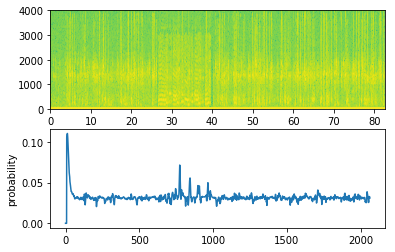

In [108]:
filename = "./data/test/test_1.wav"
prediction = detect_triggerword(filename)

We can see that the model identifies the troll, but that is where it was trained on. Lets see how it goes on a non-troll sample

FileNotFoundError: [Errno 2] No such file or directory: './data/train/regular/15.wav'

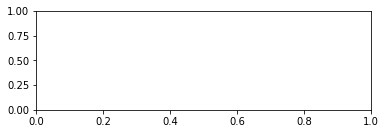

In [94]:
filename  = "./data/train/regular/15.wav"
prediction = detect_triggerword(filename)

Again, not too bad, it stays bellow 60% all the time.

However, we would have to run it against a real-world sample, from those we have collected. I did not manage to convert the real-world samples to the same dimensions of the model input.

**TODO:** convert the real-world samples to the expected spectrogram dimensions in the model input